# PROYECTO 2023

Descripción proyecto

## Importar librerías

In [ ]:
%pip install numpy --upgrade
%pip install mahotas

In [2]:
# General
import numpy as np
import math
import os

# Procesamiento de imagenes
import cv2

# Visualizacion
from   tqdm.auto import tqdm
import matplotlib.pyplot as plt

# Extraccion/seleccion de caracteristicas, clasificacion, evaluacion
from   balu3.fx.geo    import fourierdes, hugeo, flusser, gupta,basicgeo # caracteristicas geometricas?
from   balu3.fx.chr    import lbp, haralick, gabor, hog
from   balu3.ft.norm   import minmax
from   balu3.fs.sel    import jfisher,sfs,clean, exsearch
from   balu3.io.misc   import imageload
from   balu3.cl.basics import ClassifierKNN
from   balu3.ft.trans  import pca
from scipy.stats import mode
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from skimage.measure import moments
from skimage.feature import graycomatrix, daisy, graycoprops
from sklearn.decomposition import PCA, FastICA
from sklearn.feature_selection import SequentialFeatureSelector, SelectKBest, RFE, RFECV, mutual_info_classif ## fisher_score, 
from sklearn.cross_decomposition import PLSRegression 

from mlxtend.feature_selection import SequentialFeatureSelector as mlxsfs
from mahotas.features import zernike_moments

### Parámetros Extracción

In [207]:
IMG_HEIGHT = (800 // 1.2)
IMG_WIDTH = 380

# LBP
LBP_HDIV = LBP_VDIV = 3
LBP_BINS = 59

# Haralick
HAR_DISTANCE = 3
HAR_SIZE = 24

# Gabor
GAB_ROTATIONS = 8
GAB_DILATATIONS = 8

# HOG
HOG_ORIENTATIONS = 9

# Zernike
ZER_RADIUS = 30
ZER_DEGREE = 8
ZER_SIZE = 25

# GLCM
GLCM_DISTANCES = 1
GLCM_ANGLES = [0, np.pi/4, np.pi/2, 3*np.pi/4]
GLCM_LEVELS = 4

GLCM_SIZE = GLCM_LEVELS

# Daisy
DAISY_RINGS = 1
DAISY_STEP = 150
DAISY_RADIUS = 50
DAISY_ORIENTATIONS = 8
DAISY_HISTOGRAMS = 5
DAISY_P = math.ceil((IMG_WIDTH - DAISY_RADIUS * 2) / DAISY_STEP) 
DAISY_Q = math.floor((IMG_HEIGHT - DAISY_RADIUS * 2) / DAISY_STEP)
DAISY_R = (DAISY_RINGS * DAISY_HISTOGRAMS + 1) * DAISY_ORIENTATIONS

# Fetaures
features_per_function = {
    "lbp": LBP_HDIV * LBP_VDIV * LBP_BINS,
    "haralick": HAR_SIZE,
    "gabor": GAB_ROTATIONS * GAB_DILATATIONS + 3,
    "hog": HOG_ORIENTATIONS,
    "zernike": ZER_SIZE,
    "glcm": GLCM_SIZE,
    "daisy": DAISY_P * DAISY_Q * DAISY_R
}
print(features_per_function)

{'lbp': 531, 'haralick': 24, 'gabor': 67, 'hog': 9, 'zernike': 25, 'glcm': 4, 'daisy': 288}


### Parámetros Selección

In [201]:
# SFS
N_SFS = 100

# Exhaustive
N_EX = 5

# RFECV
RFECV_STEP = 1
RFECV_CV = 5

# SBS
N_SBS = 100
SBS_VERBOSE = 2
SBS_CV = 100

# PCA
N_PCA = 100

# ICA
N_ICA = 100
ICA_RANDOM_STATE = 0

# PLSR
N_PLSR = 100

### Funciones auxiliares

In [213]:
LBP_HDIV = LBP_VDIV = 3
DAISY_RINGS = 1

def transform_to_polar(img):
    size = img.shape[0]
    new_size = int(size // 1.2)
    img = img[size - new_size: new_size, size - new_size: new_size]
    value = np.sqrt(((img.shape[0]/2.0)**2.0)+((img.shape[1]/2.0)**2.0))
    
    polar_image = cv2.linearPolar(img,(img.shape[0]/2, img.shape[1]/2), value, cv2.WARP_FILL_OUTLIERS)
    
    polar_image = polar_image[:,:380]

    return polar_image


def extract_features(color_mode, dataset_type, feature_type):
    # Cargar rutas de imágenes y etiquetas según el dataset_type
    # ...
    K = 90   # <= NUMERO DE CLASES

    if dataset_type == 'train':
        fpath = "G00"     # <= DIRERCTORIO DE LA BASE DE DATOS
        N = 12   # <= NUMERO DE IMAGENES POR CLASE
        n = range(12)

    elif dataset_type == 'test':
        fpath = "G01"     # <= DIRERCTORIO DE LA BASE DE DATOS
        N = 4   # <= NUMERO DE IMAGENES POR CLASE
        n = range(12, 16)

    elif dataset_type == 'test2':
        fpath = "G02"     # <= DIRERCTORIO DE LA BASE DE DATOS
        N = 4   # <= NUMERO DE IMAGENES POR CLASE
        n = range(16, 20)

    dig_clase = 3     # <= NÚMERO DE DÍGITOS POR CLASE
    dig_img = 3     # <= NÚMERO DE DÍGITOS POR NÚMERO DE IMAGEN
    prefix = "ID"     # <= PREFIJO DEL NOMBRE DEL ARCHIVO DE LA IMAGEN
    imprefix = fpath + '/' + prefix

    # ground truth (clasificacion ideal)
    y = np.zeros((K*N), 'int')
    features = np.zeros((K*N, features_per_function[feature_type]))

    t = 0
    for j in tqdm(range(K)):                  # para cada clase
        for i in n:                # para cada imagen de la clase
            # Lectura de la imagen
            clase = j+1
            num_img = i+1
            img = imageload(imprefix, clase, dig_clase,
                            num_img, dig_img)
            img = transform_to_polar(img)
            y[t] = j+1
            t = t+1

            # Preprocesar las imágenes según el color_mode (blue, red, green, blue)
            if color_mode == 'gray':
                img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            elif color_mode == 'red':
                img = img[:, :, 0]
            elif color_mode == 'green':
                img = img[:, :, 1]
            elif color_mode == 'blue':
                img = img[:, :, 2]
            else:
                raise ValueError(f"Invalid color mode: {color_mode}")

            # Extraer características según el feature_type
            if feature_type == 'lbp':
                # Aplicar LBP a cada imagen
                features[t:, ] = lbp(img, hdiv=LBP_HDIV, vdiv=LBP_VDIV)

            elif feature_type == 'haralick':
                # Aplicar características de textura Haralick a cada imagen
                # Implementa tu propia función para la extracción de características Haralick
                features[t:, ] = haralick(img, distance=HAR_DISTANCE,)

            elif feature_type == 'gabor':
                # Aplicar filtro de Gabor a cada imagen
                # Implementa tu propia función para la extracción de características Gabor
                features[t:, ] = gabor(
                    img, rotations=GAB_ROTATIONS, dilations=GAB_DILATATIONS)

            elif feature_type == 'hog':
                # Aplicar HOG a cada imagen
                features[t:, ] = hog(img, orientations=HOG_ORIENTATIONS, pixels_per_cell=(
                    img.shape[0], img.shape[1]), cells_per_block=(1, 1))

            elif feature_type == 'zernike':
                # Aplicar momentos de Zernike a cada imagen
                # Implementa tu propia función para la extracción de características Zernike
                features[t:, ] = zernike_moments(img, radius=ZER_RADIUS, degree=ZER_DEGREE)

            elif feature_type == 'glcm':
                img_uint = img.astype(np.uint8)
                # Aplicar GLCM (Matriz de co-ocurrencia de niveles de gris) a cada imagen
                glcm = graycomatrix(img_uint, [GLCM_DISTANCES], GLCM_ANGLES, levels=GLCM_LEVELS)
                contrast = graycoprops(glcm, 'contrast')
                # Compute desired GLCM properties (e.g., contrast, energy, correlation, etc.)
                features[t:, ] = np.concatenate(contrast)

            elif feature_type == 'daisy':
                # Aplicar Daisy a cada imagen
                features[t:, ] = daisy(img, step=DAISY_STEP, radius=DAISY_RADIUS, rings=DAISY_RINGS,
                                    histograms=DAISY_HISTOGRAMS, orientations=DAISY_ORIENTATIONS).flatten()

            else:
                raise ValueError(f"Invalid feature_type: {feature_type}")

        features = np.array(features)

    # Devolver las características extraídas y las etiquetas
    return features, y


def load_features(color, set, function):
    # !wget https://www.dropbox.com/caracteristicas.npz?dl=0
    # !mv caracteristicas.npz?dl=0 caracteristicas.npz

    loaded_caracteristicas = np.load('caracteristicas.npz')
    y = loaded_caracteristicas['y']
    pass


def select_features(xtrain, xtest, ytrain, algorithm, color, step=1):
    # SELECCIÓN:
    if algorithm == 'SFS':
        # SFS: Sequential Feature Selection
        selector = sfs(xtrain, ytrain, n_features=N_SFS, show=True)
        np.save(f"selection01_steps/sfs{step}_idxs_{color}.npy", selector)
        Xtrain_sel = xtrain[:, selector]
        Xtest_sel  = xtest[:, selector]

    elif algorithm == 'EX':
        # Exhaustive Search
        selector = exsearch(xtrain, ytrain, N_EX)
        Xtrain_sel = xtrain[:, selector]
        Xtest_sel  = xtest[:, selector]

    elif algorithm == 'RFECV':
        # Recursive Feature Elimination
        estimator = SVC(kernel='linear')
        selector = RFECV(estimator, step=RFECV_STEP, cv=5)
        selector  = selector.fit(xtrain, ytrain)
        selector       = np.nonzero(selector.support_)[0]
        Xtrain_sel = xtrain[:, selector]
        Xtest_sel  = xtest[:, selector]

    elif algorithm == 'RFE':
        # RFE
        estimator = SVC(kernel='linear')
        selector = RFE(estimator)
        selector  = selector.fit(xtrain, ytrain)
        selector  = np.nonzero(selector.support_)[0]
        Xtrain_sel = xtrain[:, selector]
        Xtest_sel  = xtest[:, selector]

    elif algorithm == 'SBS':
        # SBS
        estimator = KNeighborsClassifier(n_neighbors=5)
        selector = mlxsfs(estimator, k_features=N_SBS, forward=False, floating=False, verbose=SBS_VERBOSE, scoring='accuracy', cv=SBS_CV)
        selector = selector.fit(xtrain, ytrain)
        selector = list(selector.k_feature_idx_)
        Xtrain_sel = xtrain[:, selector]
        Xtest_sel  = xtest[:, selector]

    # TRANSFORMACIÓN:
    elif algorithm == 'PCA':
        # PCA: Principal Component Analysis
        Xtrain_sel, _, A, Xm, _  = pca(xtrain, n_components=N_PCA)
        Xtest_sel = np.matmul(xtest - Xm, A)
        np.save(f"selection01_steps/pca_Xm{step}_{color}.npy", Xm)
        np.save(f"selection01_steps/pca_A{step}_{color}.npy", A)
        print('PCA done')

    elif algorithm == 'ICA':
        # ICA: Independent Component Analysis
        selector = FastICA(n_components=N_ICA, random_state=ICA_RANDOM_STATE)
        selector.fit(xtrain, ytrain)
        Xtrain_sel = selector.transform(xtrain)
        Xtest_sel = selector.transform(xtest)
    
    elif algorithm == 'PLSR':
        selector = PLSRegression(n_components=N_PLSR)
        selector.fit(xtrain, ytrain)    
        Xtrain_sel = selector.transform(xtrain)
        Xtest_sel  = selector.transform(xtest)

    # SELECCIÓN + TRANSFORMACIÓN:
    elif algorithm == 'SEL_01':
        Xtrain_sel, Xtest_sel = selection_01(xtrain, xtest, ytrain, color)

    elif algorithm == 'SEL_02':
        Xtrain_sel, Xtest_sel = selection_02(xtrain, xtest, ytrain)

    elif algorithm == 'SEL_03':
        Xtrain_sel, Xtest_sel = selection_03(xtrain, xtest, ytrain)

    else:
        raise ValueError(f"Invalid algorithm: {algorithm}")

    return Xtrain_sel, Xtest_sel


def load_selected_features(algorithm):
    pass


def load_classifier(classifier):
    if classifier == 'knn':
        return KNeighborsClassifier()
    elif classifier == 'lda':
        return LinearDiscriminantAnalysis()
    elif classifier == 'qda':
        return QuadraticDiscriminantAnalysis()
    elif classifier == 'árboles de decisión':
        return DecisionTreeClassifier()
    elif classifier == 'random forest':
        return RandomForestClassifier()
    elif classifier == 'svm lineal':
        return SVC(kernel='linear')
    elif classifier == 'svm rbf':
        return SVC(kernel='rbf')
    elif classifier == 'redes neuronales':
        return MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=1000)
    else:
        raise ValueError(f"Invalid classifier: {classifier}")


def load_trained_classifier():
    pass


def selection_01(Xtrain, Xtest, ytrain, color): 
    ''' clean-->Norm-->SFS--+-------+-->Concatenate-->SFS-->OUT
                            |       |
                            +--PCA--+
    '''
    ### Clean ###
    sclean = clean(Xtrain)
    print(Xtrain.shape, color)
    np.save(f"selection01_steps/clean_{color}.npy", sclean)
    Xtrain_clean = Xtrain[:,sclean]
    Xtest_clean = Xtest[:,sclean]
    ### Normalización ###
    Xtrain_norm, a, b = minmax(Xtrain_clean)
    Xtest_norm = Xtest_clean * a + b
    np.save(f"selection01_steps/norm_{color}.npy", [a, b])
    ### SFS 1 ###
    print(Xtrain_norm.shape)
    Xtrain_sfs1, Xtest_sfs1 = select_features(Xtrain_norm, Xtest_norm, ytrain, 'SFS', color)
    ### PCA ###
    Xtrain_pca, Xtest_pca = select_features(Xtrain_sfs1, Xtest_sfs1, ytrain, 'PCA', color, step=2)
    ### Concatenación ###
    Xtrain_aux = np.concatenate((Xtrain_sfs1, Xtrain_pca), axis=1)
    Xtest_aux = np.concatenate((Xtest_sfs1, Xtest_pca), axis=1)
    ### SFS 2 ###
    Xtrain_sfs2, Xtest_sfs2 = select_features(Xtrain_aux, Xtest_aux, ytrain, 'SFS', color, step=2)
    #######
    return Xtrain_sfs2, Xtest_sfs2


def selection_02(Xtrain, Xtest, ytrain):
    '''
                        +-->PCA---+
                        |         |
    clean-->Norm-->SFS--+-->ICA---+-->Concatenate-->SFS-->OUT
                        |         |
                        +-->PLSR--+
    '''
    ### Clean ###
    sclean = clean(Xtrain)
    Xtrain_clean = Xtrain[:,sclean]
    Xtest_clean = Xtest[:,sclean]
    ### Normalización ###
    Xtrain_norm, a, b = minmax(Xtrain_clean)
    Xtest_norm = Xtest_clean * a + b
    ### SFS 1 ###
    Xtrain_sfs1, Xtest_sfs1 = select_features(Xtrain_norm, Xtest_norm, ytrain, 'SFS')
    ### PCA ###
    Xtrain_pca, Xtest_pca = select_features(Xtrain_sfs1, Xtest_sfs1, ytrain, 'PCA')
    ### PLSR ###
    Xtrain_plsr, Xtest_plsr = select_features(Xtrain_sfs1, Xtest_sfs1, ytrain, 'PLSR')
    ### ICA ###
    Xtrain_ica, Xtest_ica = select_features(Xtrain_sfs1, Xtest_sfs1, ytrain, 'ICA')
    ### Concatenación ###
    Xtrain_aux = np.concatenate((Xtrain_pca, Xtrain_ica, Xtrain_plsr), axis=1)
    Xtest_aux = np.concatenate((Xtest_pca, Xtest_ica, Xtest_plsr), axis=1)
    ### SFS 2 ###
    Xtrain_sfs2, Xtest_sfs2 = select_features(Xtrain_aux, Xtest_aux, ytrain, 'SFS')
    #######
    return Xtrain_sfs2, Xtest_sfs2


def selection_03(Xtrain, Xtest, ytrain):
    '''
        clean-->Norm-->SFS-+-->EX---+-->PCA-->SFS-->OUT
                           |        |
                           +-->RFE--+
    '''
    ### Clean ###
    sclean = clean(Xtrain)
    Xtrain_clean = Xtrain[:,sclean]
    Xtest_clean = Xtest[:,sclean]
    ### Normalización ###
    Xtrain_norm, a, b = minmax(Xtrain_clean)
    Xtest_norm = Xtest_clean * a + b
    ### SFS 1 ###
    Xtrain_sfs1, Xtest_sfs1 = select_features(Xtrain_norm, Xtest_norm, ytrain, 'SFS')
    ### Búsqueda Exhaustiva ###
    Xtrain_ex, Xtest_ex = select_features(Xtrain_sfs1, Xtest_sfs1, ytrain, 'EX')
    ### RFE ###
    Xtrain_rfe, Xtest_rfe = select_features(Xtrain_sfs1, Xtest_sfs1, ytrain, 'RFE')
    ### Concatenación ###
    Xtrain_aux = np.concatenate((Xtrain_ex, Xtrain_rfe), axis=1)
    Xtest_aux = np.concatenate((Xtest_ex, Xtest_rfe), axis=1)
    ### PCA ###
    Xtrain_pca, Xtest_pca = select_features(Xtrain_aux, Xtest_aux, ytrain, 'PCA')
    ### SFS 2 ###
    Xtrain_sfs2, Xtest_sfs2 = select_features(Xtrain_pca, Xtest_pca, ytrain, 'SFS')
    return Xtrain_sfs2, Xtest_sfs2

### Cargar imagenes

In [ ]:
!wget https://www.dropbox.com/s/s4opefjionbdbab/G00.zip
!unzip -qq G00.zip

In [ ]:
!wget https://www.dropbox.com/s/zur2wxzcce4qlgf/G01.zip
!unzip -qq G01.zip

## Extracción y selección de caracteristicas

In [215]:
def extraction_main(extraction_models, color_modes, image_set):
    # Create the "features" folder if it doesn't exist
    if not os.path.exists("features"):
        os.makedirs("features")
    if not os.path.exists("y"):
        os.makedirs("y")

    # Iterate over extraction models and color modes
    for model in tqdm(extraction_models):
        for color_mode in color_modes:
            # Extract features
            (X, y) = extract_features(color_mode, image_set, model)

            # Save features to files
            filename = f"features/X_{image_set}_{model}_{color_mode}.npy"
            y_filename = f"y/y_{image_set}.npy"

            np.save(filename, X)
            np.save(y_filename, y)

selection_models = ['SEL_01']

color_modes = ["gray", "blue", "red", "green"]

def select_main(selection_models, color_modes):

    caract_modes = ['haralick', 'hog', 'zernike', 'lbp', 'glcm', 'daisy']
    
    # Create the "features" folder if it doesn't exist
    if not os.path.exists("selected_features"):
        os.makedirs("selected_features")

    ytrain = np.load(f'y/y_train.npy')
    ytest = np.load(f'y/y_test.npy')

    ##CONCATENAR POR COLOR
    Xtrain_gray     = np.load(f'features/X_train_haralick_gray.npy')
    Xtest_gray      = np.load(f'features/X_test_haralick_gray.npy')
    Xtrain_blue     = np.load(f'features/X_train_haralick_blue.npy')
    Xtest_blue      = np.load(f'features/X_test_haralick_blue.npy')
    Xtrain_red      = np.load(f'features/X_train_haralick_red.npy')
    Xtest_red       = np.load(f'features/X_test_haralick_red.npy')
    Xtrain_green    = np.load(f'features/X_train_haralick_green.npy')
    Xtest_green     = np.load(f'features/X_test_haralick_green.npy')
    for caract in caract_modes[1:]:
        if (caract == "lbp") | (caract == "daisy"):
            Xtrain_gray_aux, Xtest_gray_aux = select_features(np.load(f'features/X_train_{caract}_gray.npy'), np.load(f'features/X_test_{caract}_gray.npy'), ytrain, algorithm='PCA', color="gray", step=caract)
            Xtrain_blue_aux, Xtest_blue_aux = select_features(np.load(f'features/X_train_{caract}_blue.npy'), np.load(f'features/X_test_{caract}_blue.npy'), ytrain, algorithm='PCA', color="blue", step=caract)
            Xtrain_red_aux, Xtest_red_aux = select_features(np.load(f'features/X_train_{caract}_red.npy'), np.load(f'features/X_test_{caract}_red.npy'), ytrain, algorithm='PCA', color="red", step=caract)
            Xtrain_green_aux, Xtest_green_aux = select_features(np.load(f'features/X_train_{caract}_green.npy'), np.load(f'features/X_test_{caract}_green.npy'), ytrain, algorithm='PCA', color="green", step=caract)
        else:
            Xtrain_gray_aux = np.load(f'features/X_train_{caract}_gray.npy')
            Xtest_gray_aux  = np.load(f'features/X_test_{caract}_gray.npy')
            Xtrain_blue_aux = np.load(f'features/X_train_{caract}_blue.npy')
            Xtest_blue_aux  = np.load(f'features/X_test_{caract}_blue.npy')
            Xtrain_red_aux = np.load(f'features/X_train_{caract}_red.npy')
            Xtest_red_aux  = np.load(f'features/X_test_{caract}_red.npy')
            Xtrain_green_aux = np.load(f'features/X_train_{caract}_green.npy')
            Xtest_green_aux  = np.load(f'features/X_test_{caract}_green.npy')


        Xtrain_gray     = np.concatenate((Xtrain_gray,  Xtrain_gray_aux), axis=1)
        Xtest_gray      = np.concatenate((Xtest_gray,   Xtest_gray_aux), axis=1)
        Xtrain_blue     = np.concatenate((Xtrain_blue,  Xtrain_blue_aux), axis=1)
        Xtest_blue      = np.concatenate((Xtest_blue,   Xtest_blue_aux), axis=1)
        Xtrain_red      = np.concatenate((Xtrain_red,   Xtrain_red_aux), axis=1)
        Xtest_red       = np.concatenate((Xtest_red,    Xtest_red_aux), axis=1)
        Xtrain_green    = np.concatenate((Xtrain_green, Xtrain_green_aux), axis=1)
        Xtest_green     = np.concatenate((Xtest_green,  Xtest_green_aux), axis=1)

    ##SELECCIONAR CARACTERISTICAS
    for model in selection_models:

        print('START SELECTION \n')
        Xtrain_sel_gray, Xtest_sel_gray = select_features(Xtrain_gray, Xtest_gray, ytrain, model, "gray")
        print(f'Selection_gray_{model}')
        np.save(f'selected_features/X_train_{model}_gray.npy', Xtrain_sel_gray)
        np.save(f'selected_features/X_test_{model}_gray.npy', Xtest_sel_gray)

        Xtrain_sel_blue, Xtest_sel_blue = select_features(Xtrain_blue, Xtest_blue, ytrain, model, "blue")
        print(f'Selection_blue_{model}')
        np.save(f'selected_features/X_train_{model}_blue.npy', Xtrain_sel_blue)
        np.save(f'selected_features/X_test_{model}_blue.npy', Xtest_sel_blue)

        Xtrain_sel_red, Xtest_sel_red = select_features(Xtrain_red, Xtest_red, ytrain, model, "red")
        print(f'Selection_red_{model}')
        np.save(f'selected_features/X_train_{model}_red.npy', Xtrain_sel_red)
        np.save(f'selected_features/X_test_{model}_red.npy', Xtest_sel_red)

        Xtrain_sel_green, Xtest_sel_green = select_features(Xtrain_green, Xtest_green, ytrain, model, "green")
        print(f'Selection_green_{model}')
        np.save(f'selected_features/X_train_{model}_green.npy', Xtrain_sel_green)
        np.save(f'selected_features/X_test_{model}_green.npy', Xtest_sel_green)
        


In [218]:
Xtrain_gray_aux = np.load(f'selected_features/X_train_SEL_01_gray.npy')
Xtest_gray_aux  = np.load(f'selected_features/X_test_SEL_01_gray.npy')
Xtrain_blue_aux = np.load(f'selected_features/X_train_SEL_01_blue.npy')
Xtest_blue_aux  = np.load(f'selected_features/X_test_SEL_01_blue.npy')
Xtrain_red_aux = np.load(f'selected_features/X_train_SEL_01_red.npy')
Xtest_red_aux  = np.load(f'selected_features/X_test_SEL_01_red.npy')
Xtrain_green_aux = np.load(f'selected_features/X_train_SEL_01_green.npy')
Xtest_green_aux  = np.load(f'selected_features/X_test_SEL_01_green.npy')

Xtrain = np.concatenate((Xtrain_gray_aux, Xtrain_blue_aux, Xtrain_red_aux, Xtrain_green_aux), axis=1)
Xtest = np.concatenate((Xtest_gray_aux, Xtest_blue_aux, Xtest_red_aux, Xtest_green_aux), axis=1)
ytrain = np.load(f'y/y_train.npy')

Xtrain_sel, Xtest_sel = select_features(Xtrain, Xtest, ytrain, algorithm='PCA', step="all", color="all")

np.save(f'selected_features/X_train_SEL_01_all.npy', Xtrain_sel)
np.save(f'selected_features/X_test_SEL_01_all.npy', Xtest_sel)

# Xtrain_gray_aux = np.load(f'selected_features/X_train_SEL_02_gray.npy')
# Xtest_gray_aux  = np.load(f'selected_features/X_test_SEL_02_gray.npy')
# Xtrain_blue_aux = np.load(f'selected_features/X_train_SEL_02_blue.npy')
# Xtest_blue_aux  = np.load(f'selected_features/X_test_SEL_02_blue.npy')
# Xtrain_red_aux = np.load(f'selected_features/X_train_SEL_02_red.npy')
# Xtest_red_aux  = np.load(f'selected_features/X_test_SEL_02_red.npy')
# Xtrain_green_aux = np.load(f'selected_features/X_train_SEL_02_green.npy')
# Xtest_green_aux  = np.load(f'selected_features/X_test_SEL_02_green.npy')

# Xtrain = np.concatenate((Xtrain_gray_aux, Xtrain_blue_aux, Xtrain_red_aux, Xtrain_green_aux), axis=1)
# Xtest = np.concatenate((Xtest_gray_aux, Xtest_blue_aux, Xtest_red_aux, Xtest_green_aux), axis=1)

# Xtrain_sel, Xtest_sel = select_features(Xtrain, Xtest, ytrain, algorithm='PCA')

# np.save(f'selected_features/X_train_SEL_02_all.npy', Xtrain_sel)
# np.save(f'selected_features/X_test_SEL_02_all.npy', Xtest_sel)


PCA done


In [7]:
Xtrain_gray_aux = np.load(f'selected_features/X_train_SEL_01_gray.npy')
Xtest_gray_aux  = np.load(f'selected_features/X_test_SEL_01_gray.npy')

Xtrain_blue_aux = np.load(f'selected_features/X_train_SEL_02_blue.npy')
Xtest_blue_aux  = np.load(f'selected_features/X_test_SEL_02_blue.npy')

print(Xtrain_gray_aux.shape)
print(Xtest_gray_aux.shape)
print(Xtrain_blue_aux.shape)
print(Xtest_blue_aux.shape)

(1080, 100)
(360, 100)
(1080, 100)
(360, 100)


## Clasificación

### De acá en adelante se pueden ejecutar los modelos 1 y 2 

In [ ]:
## ARCHIVOS CON CARACTERISTICAS SELECCIONADAS

!wget https://www.dropbox.com/s/tivfqnxt8cbz3yq/selected.zip
!unzip -qq selected.zip

descargar caracteristicas seleccionadas

### Ensamble de clasificadores

In [8]:
def majority_voting_ensemble(models, X_test):
    predictions = np.array([model.predict(X_test) for model in models])
    majority_vote = mode(predictions, axis=0)
    return majority_vote.mode.flatten()

## MODELO 1

descripción del modelo

In [10]:
def modelo_1(X_train, y_train):

    models = [load_classifier('knn'), load_classifier('lda'), load_classifier('qda'),
          load_classifier('árboles de decisión'), load_classifier('random forest'),
          load_classifier('svm lineal'), load_classifier('svm rbf'),
          load_classifier('redes neuronales')]
          
    # Dividir el conjunto de entrenamiento en entrenamiento y prueba (Hold Out)
    X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_train, y_train, test_size=4, random_state=42)
    
    best_model = None
    best_accuracy = 0.0

    # Iterar sobre diferentes modelos y encontrar el que maximice la precisión
    for model in models:
        # Entrenar el modelo con el conjunto de entrenamiento
        model.fit(X_train_1, y_train_1)

        # Predecir las etiquetas para el conjunto de prueba
        y_pred = model.predict(X_test_1)

        # Calcular la precisión del modelo
        accuracy = accuracy_score(y_test_1, y_pred)

        # Actualizar el mejor modelo si se encuentra uno con una precisión mayor
        model.fit(X_train, y_train)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model = model
    
    # Entregar el mejor modelo encontrado
    entregable_modelo_1 = best_model

    return models, entregable_modelo_1

## MODELO 2

descripción del modelo

In [11]:
def model_2(X_train, y_train):
    models = [load_classifier('knn'), load_classifier('lda'), load_classifier('qda'),
          load_classifier('árboles de decisión'), load_classifier('random forest'),
          load_classifier('svm lineal'), load_classifier('svm rbf'),
          load_classifier('redes neuronales')]
    
    best_model = None
    best_accuracy = 0.0
    # Iterar sobre diferentes modelos y encontrar el que maximice la precisión en cross-val
    for model in models:
        # Realizar cross-val con 4 folds en las imágenes de grupo 0
        scores = cross_val_score(model, X_train, y_train, cv=4)

        # Calcular la precisión promedio en cross-val
        accuracy = scores.mean()

        # Actualizar el mejor modelo si se encuentra uno con una precisión mayor
        model.fit(X_train, y_train)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model = model

    # Entregar el mejor modelo encontrado
    entregable_modelo_2 = best_model

    return models, entregable_modelo_2

## MODELO 3

In [12]:
def model_3(X, y):

    models = [load_classifier('knn'), load_classifier('lda'), load_classifier('qda'),
          load_classifier('árboles de decisión'), load_classifier('random forest'),
          load_classifier('svm lineal'), load_classifier('svm rbf'),
          load_classifier('redes neuronales')]
    
    best_model = None
    best_accuracy = 0.0

    n_folds = 5
    skf = StratifiedKFold(n_splits=n_folds)

    for model in models:
      accuracies = np.array([])
      for i, (train_index, test_index) in enumerate(skf.split(X, y)):
            X_train_3, X_test_3 = X[train_index], X[test_index]
            y_train_3, y_test_3 = y[train_index], y[test_index]

            model.fit(X_train_3, y_train_3)

            y_pred = model.predict(X_test_3)

            accuracy = accuracy_score(y_test_3, y_pred)
            
            accuracies = np.append(accuracies, accuracy)
      mean_accuracy = np.mean(accuracies)

      if mean_accuracy > best_accuracy:
            best_accuracy = mean_accuracy
            best_model = model

      best_model.fit(X, y)

    return models, best_model

In [ ]:
y_train = np.load('y/y_train.npy')
y_test = np.load('y/y_test.npy')

accs_m1 = {}
accs_m2 = {}

all_files = ["red", "green", "blue", "gray"]
for n in [1, 2]:
    accs_m1[n] = {}
    accs_m2[n] = {}
    for i in all_files:
        X_train = np.load(f'selected_features/X_train_SEL_0{n}_{i}.npy')
        X_test = np.load(f'selected_features/X_test_SEL_0{n}_{i}.npy')

        ##MODELO 1
        models, best_model_1 = modelo_1(X_train, y_train)
        y_pred_1 = best_model_1.predict(X_test)
        accuracy_1 = accuracy_score(y_test, y_pred_1)
        
        print(f"Accuracy model 1: {accuracy_1}")
        accs_m1[n][i] = accuracy_1

        y_pred_mv = majority_voting_ensemble(models, X_test)
        accuracy_mv = accuracy_score(y_test, y_pred_mv)

        print(f"Accuracy majority voting: {accuracy_mv}")
        accs_m1[n][f'{i}_mv'] = accuracy_mv

        ## MODELO 2
        models, best_model_2 = model_2(X_train, y_train)
        y_pred_2 = best_model_2.predict(X_test)
        accuracy_2 = accuracy_score(y_test, y_pred_2)

        print(f"Accuracy model 2: {accuracy_2}")
        accs_m2[n][i] = accuracy_2

        y_pred_mv = majority_voting_ensemble(models, X_test)
        accuracy_mv = accuracy_score(y_test, y_pred_mv)

        print(f"Accuracy majority voting: {accuracy_mv}")
        accs_m2[n][f'{i}_mv'] = accuracy_mv

In [38]:
print(accs_m1)
print(accs_m2)

np.save('accs_m1.npy', accs_m1)
np.save('accs_m2.npy', accs_m2)


{1: {'red': 0.6611111111111111, 'red_mv': 0.6444444444444445, 'green': 0.6361111111111111, 'green_mv': 0.6333333333333333, 'blue': 0.6222222222222222, 'blue_mv': 0.6083333333333333, 'gray': 0.6416666666666667, 'gray_mv': 0.6222222222222222}, 2: {'red': 0.6611111111111111, 'red_mv': 0.5416666666666666, 'green': 0.6361111111111111, 'green_mv': 0.5111111111111111, 'blue': 0.6222222222222222, 'blue_mv': 0.5138888888888888, 'gray': 0.6444444444444445, 'gray_mv': 0.5361111111111111}}
{1: {'red': 0.6611111111111111, 'red_mv': 0.6472222222222223, 'green': 0.6361111111111111, 'green_mv': 0.6388888888888888, 'blue': 0.6222222222222222, 'blue_mv': 0.6083333333333333, 'gray': 0.6416666666666667, 'gray_mv': 0.6305555555555555}, 2: {'red': 0.6611111111111111, 'red_mv': 0.5555555555555556, 'green': 0.6361111111111111, 'green_mv': 0.5166666666666667, 'blue': 0.6222222222222222, 'blue_mv': 0.5083333333333333, 'gray': 0.6444444444444445, 'gray_mv': 0.5333333333333333}}


## Código para ejecutar tests

Insertar link en la celda de abajo y ejecutar

In [ ]:
!wget <url>
!unzip -qq G02.zip

Si no está cargado el G01.zip

In [ ]:
!wget https://www.dropbox.com/s/zur2wxzcce4qlgf/G01.zip
!unzip -qq G01.zip

Cargar selected_features, selection_steps e y_train

In [ ]:
!wget https://www.dropbox.com/s/f22yzeacl2y2wbn/selected_features.zip
!wget https://www.dropbox.com/s/1fngntbr9bdpy1s/selection01_steps.zip
!wget https://www.dropbox.com/s/vk56ogri85txlpt/y.zip

!unzip -qq selected_features.zip
!unzip -qq selection01_steps.zip
!unzip -qq y.zip

Ejecutar celda de abajo para probar, cambiar TEST por "test" o "test2", siendo G01 Y G02 respectivamente.

In [219]:
TEST = "test"
EXTRACTION_MODS = ['haralick', 'hog', 'zernike', 'lbp', 'glcm', 'daisy']
EXTRACTION_MODS_2 = ['daisy']
COLOR_MODES = ["gray", "blue", "red", "green"]
SELECTION_MODELS = ['SEL_01']


def select01_test_features(test_set):
    Xtest_gray = None
    Xtest_blue = None
    Xtest_red = None
    Xtest_green = None
    for caract in EXTRACTION_MODS:
        Xtest_gray_aux = np.load(f'features/X_{test_set}_{caract}_gray.npy')
        Xtest_blue_aux = np.load(f'features/X_{test_set}_{caract}_blue.npy')
        Xtest_red_aux = np.load(f'features/X_{test_set}_{caract}_red.npy')
        Xtest_green_aux = np.load(f'features/X_{test_set}_{caract}_green.npy')
        if (caract == "lbp") | (caract == "daisy"):
            Xm_gray, A_gray = np.load(f'selection01_steps/pca_Xm{caract}_gray.npy'), np.load(f'selection01_steps/pca_A{caract}_gray.npy')
            Xm_blue, A_blue = np.load(f'selection01_steps/pca_Xm{caract}_blue.npy'), np.load(f'selection01_steps/pca_A{caract}_blue.npy')
            Xm_red, A_red = np.load(f'selection01_steps/pca_Xm{caract}_red.npy'), np.load(f'selection01_steps/pca_A{caract}_red.npy')
            Xm_green, A_green = np.load(f'selection01_steps/pca_Xm{caract}_green.npy'), np.load(f'selection01_steps/pca_A{caract}_green.npy')
            
            Xtest_gray_aux = np.matmul(Xtest_gray_aux - Xm_gray, A_gray)
            Xtest_blue_aux = np.matmul(Xtest_blue_aux - Xm_blue, A_blue)
            Xtest_red_aux = np.matmul(Xtest_red_aux - Xm_red, A_red)
            Xtest_green_aux = np.matmul(Xtest_green_aux - Xm_green, A_green)
        if Xtest_gray is None:
            Xtest_gray = Xtest_gray_aux
            Xtest_blue = Xtest_blue_aux
            Xtest_red = Xtest_red_aux
            Xtest_green = Xtest_green_aux
        else:
            Xtest_gray = np.concatenate((Xtest_gray,   Xtest_gray_aux), axis=1)
            Xtest_blue = np.concatenate((Xtest_blue,   Xtest_blue_aux), axis=1)
            Xtest_red = np.concatenate((Xtest_red,    Xtest_red_aux), axis=1)
            Xtest_green = np.concatenate((Xtest_green,  Xtest_green_aux), axis=1)

    # Pasos de SEL_01
    
    # Se aplica clean segun datos guardados de el entrenamiento
    clean_gray = np.load(f'selection01_steps/clean_gray.npy')
    clean_blue = np.load(f'selection01_steps/clean_blue.npy')
    clean_red = np.load(f'selection01_steps/clean_red.npy')
    clean_green = np.load(f'selection01_steps/clean_green.npy')
    
    Xtest_gray = Xtest_gray[:,clean_gray]
    Xtest_blue = Xtest_blue[:,clean_blue]
    Xtest_red = Xtest_red[:,clean_red]
    Xtest_green = Xtest_green[:,clean_green]
    
    # Se aplica normalizacion segun datos guardados de el entrenamiento
    norm_gray = np.load(f'selection01_steps/norm_gray.npy')
    norm_blue = np.load(f'selection01_steps/norm_blue.npy')
    norm_red = np.load(f'selection01_steps/norm_red.npy')
    norm_green = np.load(f'selection01_steps/norm_green.npy')
    
    X_test_gray = Xtest_gray * norm_gray[0] + norm_gray[1]
    X_test_blue = Xtest_blue * norm_blue[0] + norm_blue[1]
    X_test_red = Xtest_red * norm_red[0] + norm_red[1]
    X_test_green = Xtest_green * norm_green[0] + norm_green[1]
    
    # Se aplica el primer SFS segun datos guardados de el entrenamiento
    sfs1_gray = np.load(f'selection01_steps/sfs1_idxs_gray.npy')
    sfs1_blue = np.load(f'selection01_steps/sfs1_idxs_blue.npy')
    sfs1_red = np.load(f'selection01_steps/sfs1_idxs_red.npy')
    sfs1_green = np.load(f'selection01_steps/sfs1_idxs_green.npy')
    
    X_test_gray_sfs = X_test_gray[:,sfs1_gray]
    X_test_blue_sfs = X_test_blue[:,sfs1_blue]
    X_test_red_sfs = X_test_red[:,sfs1_red]
    X_test_green_sfs = X_test_green[:,sfs1_green]
    
    # Se aplica PCA segun datos guardados de el entrenamiento
    Xm_gray, A_gray = np.load(f'selection01_steps/pca_Xm2_gray.npy'), np.load(f'selection01_steps/pca_A2_gray.npy')
    Xm_blue, A_blue = np.load(f'selection01_steps/pca_Xm2_blue.npy'), np.load(f'selection01_steps/pca_A2_blue.npy')
    Xm_red, A_red = np.load(f'selection01_steps/pca_Xm2_red.npy'), np.load(f'selection01_steps/pca_A2_red.npy')
    Xm_green, A_green = np.load(f'selection01_steps/pca_Xm2_green.npy'), np.load(f'selection01_steps/pca_A2_green.npy')
    
    X_test_gray_pca = np.matmul(X_test_gray_sfs - Xm_gray, A_gray)
    X_test_blue_pca = np.matmul(X_test_blue_sfs - Xm_blue, A_blue)
    X_test_red_pca = np.matmul(X_test_red_sfs - Xm_red, A_red)
    X_test_green_pca = np.matmul(X_test_green_sfs - Xm_green, A_green)
    
    # Se concatenan SFS y PCA
    X_test_gray = np.concatenate((X_test_gray_sfs, X_test_gray_pca), axis=1)
    X_test_blue = np.concatenate((X_test_blue_sfs, X_test_blue_pca), axis=1)
    X_test_red = np.concatenate((X_test_red_sfs, X_test_red_pca), axis=1)
    X_test_green = np.concatenate((X_test_green_sfs, X_test_green_pca), axis=1)
    
    # Se aplica último SFS segun datos guardados de el entrenamiento
    sfs2_gray = np.load(f'selection01_steps/sfs2_idxs_gray.npy')
    sfs2_blue = np.load(f'selection01_steps/sfs2_idxs_blue.npy')
    sfs2_red = np.load(f'selection01_steps/sfs2_idxs_red.npy')
    sfs2_green = np.load(f'selection01_steps/sfs2_idxs_green.npy')
    
    X_test_gray = X_test_gray[:,sfs2_gray]
    X_test_blue = X_test_blue[:,sfs2_blue]
    X_test_red = X_test_red[:,sfs2_red]
    X_test_green = X_test_green[:,sfs2_green]
    
    X_test = np.concatenate((X_test_gray, X_test_blue, X_test_red, X_test_green), axis=1)
    
    # Se aplica ultimo PCA segun datos guardados de el entrenamiento
    Xm_all, A_all = np.load(f'selection01_steps/pca_Xmall_all.npy'), np.load(f'selection01_steps/pca_Aall_all.npy')
    
    X_test = np.matmul(X_test - Xm_all, A_all)
    
    return X_test
    

def test_set(test_set):
    # select_main(SELECTION_MODELS, COLOR_MODES)
    # return
    # Cargar entrenamiento
    X_train = np.load('selected_features/X_train_SEL_01_all.npy')
    y_train = np.load('y/y_train.npy')

    # Crear set de test
    # extraction_main(EXTRACTION_MODS_2, COLOR_MODES, test_set)
    # extraction_main(EXTRACTION_MODS, COLOR_MODES, 'train')
    # return
    X_test = select01_test_features(test_set)
    y_test = np.load(f'y/y_{test_set}.npy')

    ##MODELO 1
    models, best_model_1 = modelo_1(X_train, y_train)
    y_pred_1 = best_model_1.predict(X_test)
    accuracy_m1 = accuracy_score(y_test, y_pred_1)
    
    print(f"Accuracy model 1: {accuracy_m1}")

    ## MODELO 2
    models, best_model_2 = model_2(X_train, y_train)
    y_pred_2 = best_model_2.predict(X_test)
    accuracy_m2 = accuracy_score(y_test, y_pred_2)

    print(f"Accuracy model 2: {accuracy_m2}")
    
    ## MODELO 3
    models, best_model_3 = model_3(X_train, y_train)
    y_pred_3 = best_model_3.predict(X_test)
    accuracy_m3 = accuracy_score(y_test, y_pred_3)

    print(f"Accuracy model 3: {accuracy_m3}")
    


test_set(TEST)


Accuracy model 1: 0.5861111111111111
Accuracy model 2: 0.5861111111111111
Accuracy model 3: 0.5861111111111111


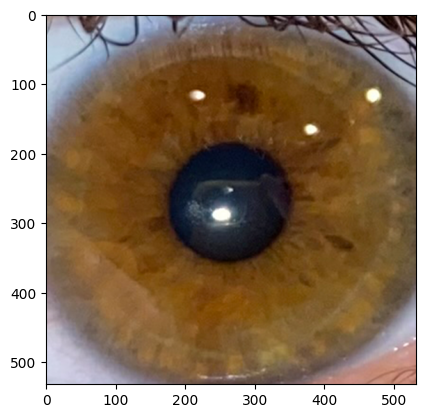

In [264]:
def transform_to_polar(img):
    size = img.shape[0]
    new_size = int(size // 1.2)
    img = img[size - new_size: new_size, size - new_size: new_size]
    value = np.sqrt(((img.shape[0]/2.0)**2.0)+((img.shape[1]/2.0)**2.0))
    polar_image = cv2.linearPolar(img,(img.shape[0]/2, img.shape[1]/2), value, cv2.WARP_FILL_OUTLIERS)
    
    polar_image = polar_image[:,:380]
    plt.imshow(img)

    # return polar_image

img = plt.imread('G01\ID083_013.png')
img = transform_to_polar(img)
# plt.imshow(img)